### Time-frequency representations of power

Oscillatory brain activity is modulated in different frequency bands depending on the tasks (Tallon-Baudry and Bertrand 1999). To quantify the frequency specific modulations, time-frequency representations (TFRs) of power are calculated per trial which then are averaged. The power is estimated using Fourier transform and a sliding-window approach. The aim of this section is to characterize the modulation of oscillatory activity in response to visual input.

#### Preparation

Import the relevant Python modules:

In [ ]:
import os.path as op
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

import mne
from mne_bids import BIDSPath, read_raw_bids


#### File overview

The chapter relies on the input file (embedded in the BIDS structure):

<BIDS_ROOT>/derivatives/Analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif

Set the paths for the data and results. Note that these will depend on your local setup.
Loading the data

In [5]:
subject = '01'
session = '01'
task = 'SpAtt'  # name of the task
run = '12'  # both runs compbined
meg_suffix = 'meg'
epo_suffix = 'epo'

data_path='/home/rakshita/rds_folders/Sproject3/OPM_data'
deriv_root=op.join(data_path,"Sub2_BIDS/derivatives/analysis")
#deriv_root=op.join(data_path,"BIDSRec_main/derivatives/analysis")
bids_path = BIDSPath(subject=subject, session=session,
            task=task, run=run, suffix=epo_suffix, datatype='meg',
            root=deriv_root, extension='.fif', check=False)
print(bids_path.basename,bids_path.fpath)

sub-01_ses-01_task-SpAtt_run-12_epo.fif /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif


Read the trial-based data stored as epochs:

In [6]:
epochs = mne.read_epochs(bids_path.fpath,
                         proj = False,
                         preload=True,
                         verbose=True)

Reading /home/rakshita/rds_folders/Sproject3/OPM_data/Sub2_BIDS/derivatives/analysis/sub-01/ses-01/meg/sub-01_ses-01_task-SpAtt_run-12_epo.fif ...
    Read a total of 8 projection items:
        HFC: l=1 m=-1 (1 x 67) active
        HFC: l=1 m=0 (1 x 67) active
        HFC: l=1 m=1 (1 x 67) active
        HFC: l=2 m=-2 (1 x 67) active
        HFC: l=2 m=-1 (1 x 67) active
        HFC: l=2 m=0 (1 x 67) active
        HFC: l=2 m=1 (1 x 67) active
        HFC: l=2 m=2 (1 x 67) active
    Found the data of interest:
        t =   -2500.00 ...    2000.00 ms
        0 CTF compensation matrices available
Not setting metadata
439 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 8)



## Time-frequency analysis of slower frequencies (<30 hz)

From experience we know that oscillations in slower frequency bands such as in the theta, alpha and beta range are fairly narrow-band (ΔF ~ 2 Hz) whereas neuronal activity in the gamma band (60 - 90 hz) is typically more broad-band (ΔF ~ 5-10 hz). For this reason we advise to use different settings for slower and faster frequencies.

We will be making use of the multi-taper technique. It is implemented as a sliding-time window approach where the Fourier transform is used to estimate the spectral power. In the MNE-Python implementation, the Fourier transform is based on a convolution-type approach. For the sliding window, data are 'tapered', i.e. one or more orthogonal tapers are multiplied to the data in the time-window prior to the Fourier-transform (Percival and Walden, 1993). These tapers are derived from discrete prolate spheroidal sequences (DPSS).

Prior to the analysis, there are 3 important parameters to set.

freqs: defines the frequency range over which to perform the analysis; in this case 2 to 30 Hz in 1 Hz steps.

n_cycles: defines the length of the sliding time-window in units of cycles. For instance, for f = 10 Hz a cycle is T = 1/10 Hz = 0.1 s long. We set n_cycles = freqs/2, i.e. for any frequency the time-window is ΔT = 500 ms (e.g. for f = 10 Hz, the variable n_cycles = 5 resulting in a ΔT = 500 ms time-window).

time_bandwidth: (2ΔTΔF) determines the number of DPSS tapers to be used. It is typically an even number and the number of tapers are then N = time_bandwidth - 1. The tapers relates to the temporal (ΔT) and spectral (ΔF) smoothing: N < 2 ΔT ΔF (Percival and Walden, 1993) . In this example we set time_bandwidth = 2.0, i.e. N = 1. This results in a spectral smoothing dF > 1 Hz. As we only use one taper for the slower frequencies the actual spectral smoothing is in fact 3/2 ΔT ~ 3 Hz

To calculate the TFR for all the planar gradiometers for attention left and right condition separately write:


In [8]:
freqs = np.arange(3, 31, 2)
n_cycles = freqs / 2 
time_bandwidth = 2.0

tfr_slow_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue/left'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1,
    verbose=True)

tfr_slow_right = mne.time_frequency.tfr_multitaper(
    epochs['cue/right'], 
    freqs=freqs, 
    n_cycles=n_cycles,
    time_bandwidth=time_bandwidth, 
    picks = 'mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs= -1, 
    verbose=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:   10.5s finished


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    7.1s finished



Note that n_jobs = -1 allow for parallel execution which is more efficient if you have a multicore CPU.

Use the plot function to show the response from a posterior sensor in the interval -0.5 to 1 s with respect to the onset of the gratings.


No baseline correction applied


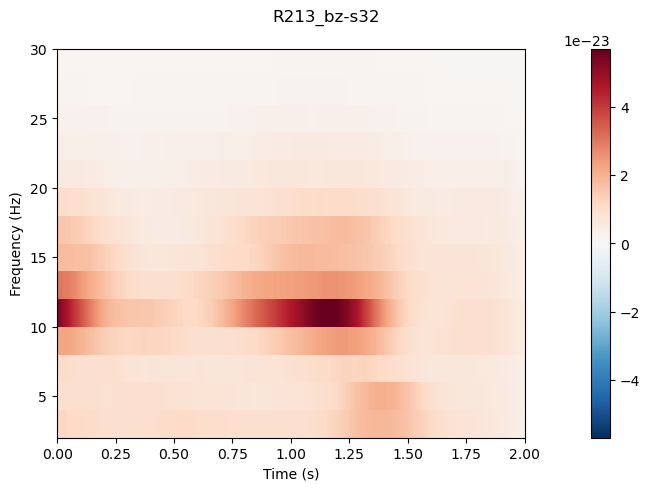

In [230]:
#'R112_bz-s39' 'R213_bz-s32''R211_bz-s34''R116_bz-s36'
%matplotlib inline
tfr_slow_left.plot(
    picks=['R213_bz-s32'],
    mode="percent", 
    tmin=0, tmax=2.0, 
    title='R213_bz-s32');  

Applying baseline correction (mode: percent)


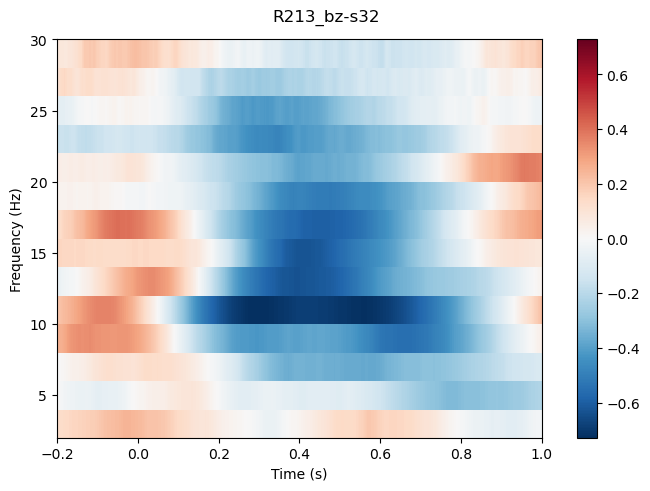

[<Figure size 640x480 with 2 Axes>]

In [238]:
tfr_slow_right.plot(
    picks=['R213_bz-s32'], 
    baseline=[-0.500,-0.250], 
    mode="percent", 
    tmin=-0.2, tmax=1,
    title='R213_bz-s32')  

In [ ]:
plt = tfr_slow_left.plot_topo(
    tmin=-0.5, tmax=1.0, 
    baseline=[-0.5,-0.3], 
    mode="percent", 
    fig_facecolor='w',
    font_color='k',
    vmin=-1, vmax=1,
    title='TFR of power <30 Hz')

Applying baseline correction (mode: percent)


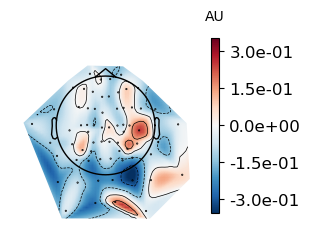

In [104]:
tfr_slow_left.plot_topomap(
    tmin=0.1, tmax=0.7, 
    fmin=9, fmax=11,
    baseline=[-1,-0.4], 
    mode="percent",
    size=3
);

In [34]:
tfr_slow_diff = tfr_slow_left.copy()
tfr_slow_diff.data = (tfr_slow_left.data - tfr_slow_right.data)/(tfr_slow_right.data + tfr_slow_left.data)

In [ ]:
tfr_slow_diff.plot_topo(
    tmin=-0.1, tmax=0.0, 
    fig_facecolor='w',
    font_color='k',
    title='Right - Left');

No baseline correction applied


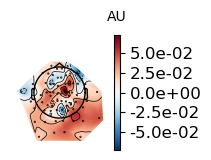

In [172]:
tfr_slow_diff.plot_topomap(tmin=0.1, tmax=0.8, 
                           fmin=9, fmax=11,
                           #baseline=[-0.8,-0.6],
                           #vlim=(-0.1, 0.1),
                          );



## Time-frequency analysis of faster frequencies (>30 hz)

To investigate spectral modulations at fast frequencies, more spectral smoothing is required. This can be achieved by the settings:

freqs: defines the frequency range over which to perform the analysis. We will consider 30 to 100 Hz in steps of 2 Hz.

n_cycles: we set the number of cycles qual to freqs / 4. This results in a time-window dT = 250 ms which is independent of frequency. The relatively short time-window insures good temporal resolution.

time_bandwidth Set the time_bandwith to 4 s. This result in N = 3 tapers. As N < 2 * dT * dF, the resulting spectral smoothing is at least 6 Hz. The relatively large spectral smoothing stems from the empirical observation that visual gamma is somewhat broad-band.

For details on the multitaper approach see see Percival and Walden (1993).

Apply these settings for the left and right attention condition (note, this step could be quite time-consuming):


In [174]:
freqs = np.arange(30, 101, 2)
n_cycles = freqs / 4 
time_bandwidth = 4.0

tfr_fast_left =  mne.time_frequency.tfr_multitaper(
    epochs['cue/left'], 
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1,
    verbose=True)

tfr_fast_right = mne.time_frequency.tfr_multitaper(
    epochs['cue/right'],
    freqs=freqs, 
    n_cycles=n_cycles, 
    time_bandwidth=time_bandwidth,
    picks='mag',
    use_fft=True, 
    return_itc=False,
    average=True, 
    decim=1,
    n_jobs = -1,
    verbose=True)


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.2min finished


NOTE: tfr_multitaper() is a legacy function. New code should use .compute_tfr(method="multitaper").


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  1.1min finished


Applying baseline correction (mode: percent)


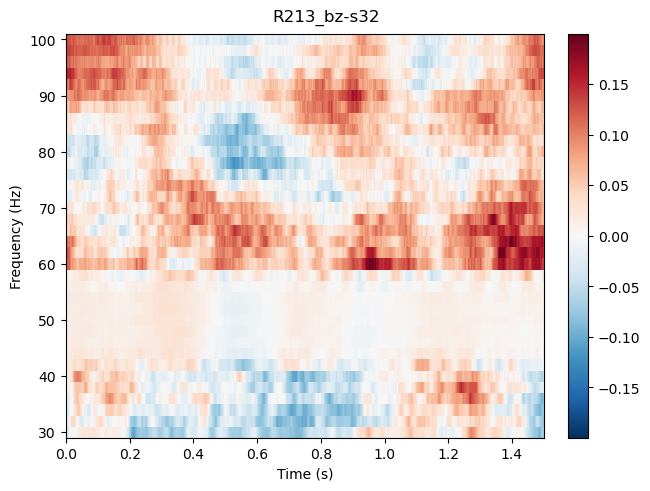

[<Figure size 640x480 with 2 Axes>]

In [181]:
tfr_fast_left.plot(
    picks=['R116_bz-s36'], 
    baseline=[-0.3,-0.2], 
    mode="percent", 
    tmin=0, tmax=1.5,
    title='R213_bz-s32') 


Applying baseline correction (mode: percent)


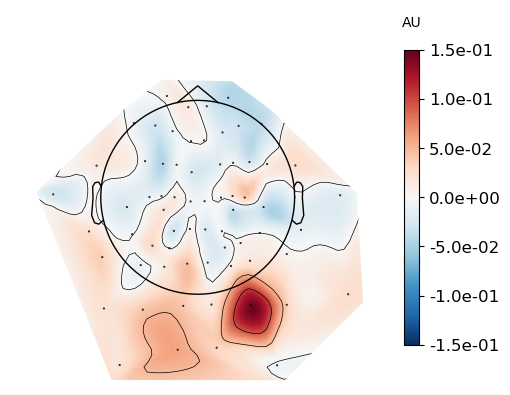

In [239]:
tfr_fast_left.plot_topomap(
    tmin=0, tmax=0.6, 
    fmin=60, fmax=90, 
    baseline = [-0.5,0], 
    mode="percent", 
    vlim=(-0.15, 0.15),
    size=5
);



Here appreciate the posterior distribution of the gamma band activity.

Next, calculate the power lateralization index (using the same equations as for the lower frequencies).


In [219]:
tfr_fast_diff = tfr_fast_left.copy()
tfr_fast_diff.data = (tfr_fast_right.data - tfr_fast_left.data)/(tfr_fast_right.data + tfr_fast_left.data)

No baseline correction applied


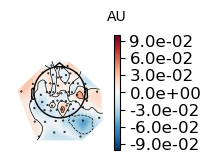

In [224]:
tfr_fast_diff.plot_topomap(
    tmin=0, tmax=0.6, 
    fmin=60, fmax=90,
    #baseline = [-0.8,-0.5],
    vlim=(-0.1, 0.1)
);

## References

Tallon-Baudry and Bertrand (1999) Oscillatory gamma activity in humans and its role in object representation. Trends Cogn Sci. 3(4):151-162

Mitra and Pesaran (1999) Analysis of dynamic brain imaging data. Biophys J. 76(2):691-708
    
Percival and Walden (1993) Spectral analysis for physical applications: multitaper and conventional univariate techniques. Cambridge, UK

